In [ ]:
import os
import numpy as np
from PIL import Image
import pydicom as dicom

In [ ]:
import cv2
import skimage.transform
import os
from sklearn.preprocessing import StandardScaler

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from skimage import io, color, transform
from sklearn.metrics import f1_score
import copy
import torch.nn.functional as F
import csv
from tqdm import tqdm
import PIL.Image

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(37)

In [ ]:
def image_viewer(output_classes, image, mask):
    x=mask[0].numpy()
    x*=output_classes # The function need the classes to be integer
    io.imshow(color.label2rgb(x, image[0].numpy(), bg_label=0)) # Set bkg transparent and shows only
                                                                #  other classes on top of the input png
plt.show()

In [ ]:
 class MR_Dataset(Dataset):

    def __init__(self, ids, image_dir, mask_dir, output_classes):
        self.ids = []
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.output_classes = output_classes
        for id in ids:
            for file in os.listdir(image_dir(id)):
              self.ids.append((id, file))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self,idx):
        id, file = self.ids[idx]
        mask_id = list(str(int(file[-9:-4])+1))
        while len(mask_id) != 5:
            mask_id.insert(0, "0")
        mask_file = f"{self.mask_dir(id)}/{file[:-9]}{''.join(mask_id)}.png"
        img_file = f"{self.image_dir(id)}/{file}"
        dcm_image = dicom.dcmread(img_file)
        pil_image = PIL.Image.fromarray(dcm_image.pixel_array).convert('RGB') # NN expect 3 channel input
        img = np.array(pil_image)
        mask= np.array(PIL.Image.open(mask_file)).astype(np.uint8)
        tmp=np.ndarray((mask.shape[0],mask.shape[1],self.output_classes),dtype=np.uint8) # NN expect 3 channel input
        for i in range(self.output_classes):
            tmp[:,:,i]=mask

        sample = {'image': img, 'mask': tmp} # matched image and mask

        sample=self.transform(sample) # Eventual transformation to be made on the input data

        return sample

    def transform(self, sample):
        image, mask = sample.values()
        isotr_img = skimage.transform.resize(image, (256, 256), order=2, preserve_range=True, mode="constant")
        factors = (3, 256, 256)
        image = cv2.normalize(isotr_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        image=cv2.medianBlur(image,3)
        mask = transforms.Resize((256, 256), interpolation=Image.NEAREST)(transforms.ToPILImage()(mask))
        to_tensor = transforms.ToTensor()
        image = to_tensor(image)
        mask = to_tensor(mask)
        image = torch.where(image >= 0.5, image, 0)
        return {"image": image, "mask": mask}


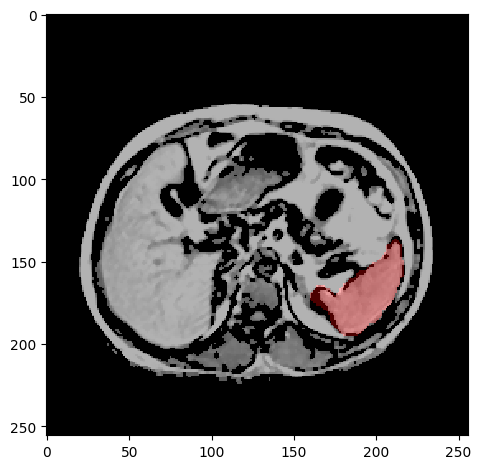

In [ ]:
tmp = MR_Dataset([2], lambda id: f"MR/{id}/T1DUAL/DICOM_anon/OutPhase", lambda id: f"MR/{id}/T1DUAL/Ground", output_classes=4)
i = 25
sample=tmp[i]
image_viewer(4,**sample)

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [ ]:
def train_model(model, criterion, dataloader, dataloader1, optimizer, metrics, bpath, num_epochs):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Logger
    fieldnames = ['epoch', 'Train_loss', 'Val_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Val_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
                dataloaders=dataloader # Select dataset for training
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders=dataloader1 #Select dataste for validation

            # Iterate over data.
            for sample in tqdm(iter(dataloaders)):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    y_pred = outputs.cpu().detach().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0, average='weighted'))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(
                phase, loss))
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, "model.pt")
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Val' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
output_classes = 4
ids = [x for x in os.listdir("MR") if x.isnumeric()]
dataset_train = MR_Dataset(ids[:16], lambda id: f"MR/{id}/T1DUAL/DICOM_anon/OutPhase", lambda id: f"MR/{id}/T1DUAL/Ground", output_classes=output_classes)
dataset_val = MR_Dataset(ids[16:], lambda id: f"MR/{id}/T1DUAL/DICOM_anon/OutPhase", lambda id: f"MR/{id}/T1DUAL/Ground", output_classes=output_classes)
dataloader = DataLoader(dataset_train, batch_size=4, shuffle = True)
dataloader1 = DataLoader(dataset_val, batch_size=2,
                      shuffle=False)
model = UNet(n_channels=3, n_classes=output_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction='mean')
metrics = {'f1_score': f1_score}
bpath = '/content/images'
my_model_trained=train_model(model, criterion, dataloader, dataloader1, optimizer, metrics, bpath, num_epochs=5)

Epoch 1/1
----------


100%|██████████| 130/130 [02:21<00:00,  1.09s/it]


Train Loss: 0.0031


100%|██████████| 64/64 [00:34<00:00,  1.84it/s]


Val Loss: 0.0161
{'epoch': 1, 'Train_loss': 0.00305121298879385, 'Val_loss': 0.01613856665790081, 'Train_f1_score': 0.4861532534274634, 'Val_f1_score': 0.27137066380263336}


In [ ]:
def decode_segmap(image, nc=4):
    label_colors = np.array([
        (0, 0, 0),     # 0=background
        (0, 255, 0),   # 1=organ1 (e.g., liver)
        (0, 0, 255),   # 2=organ2 (e.g., kidney)
        (0, 0, 0),     # 3=organ3 (e.g., spleen)
        (255, 255, 0)  # 4=organ4 (e.g., pancreas)
    ])

    rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for l in range(0, nc):
        idx = image == l
        rgb[idx] = label_colors[l]

    return rgb

0 torch.Size([1, 3, 256, 256]) torch.Size([1, 4, 256, 256])


Text(0.5, 1.0, 'gen mask')

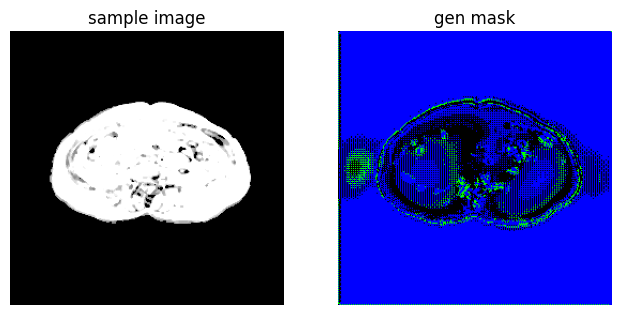

In [ ]:
test_dataloader = DataLoader(dataset_train, batch_size=1, shuffle = True)
for i_batch, sample_batched in enumerate(test_dataloader):
    print(i_batch, sample_batched['image'].size(),
      sample_batched['mask'].size())
    break

# Visualization of the model output on one example image from training
out = my_model_trained(sample_batched['image'].cuda())
om = torch.argmax(out[0].cpu(),dim=0)
rgb = decode_segmap(om)
fig=plt.figure(figsize=(12,10))

fig.add_subplot(1,3,1)
plt.imshow(sample_batched["image"][0][0], cmap="gray")
plt.axis("off")
plt.title("sample image")

fig.add_subplot(1,3,2)
plt.imshow(rgb)
plt.axis("off")
plt.title("gen mask")

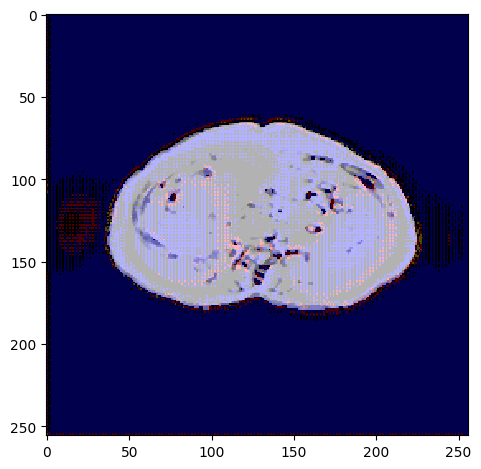

In [ ]:
def image_viewer(output_classes, image, mask):
    x=mask[0].numpy()
    x*=output_classes # The function need the classes to be integer
    io.imshow(color.label2rgb(x, image[0].numpy(), bg_label=0)) # Set bkg transparent and shows only
                                                                #  other classes on top of the input png
    plt.show()

mask = om.unsqueeze(0)
image_viewer(4, sample_batched["image"][0], mask)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/images/log.csv")

In [ ]:
plt.plot(df["epoch"], df["Train_loss"], "b", label="Training loss")
plt.plot(df["epoch"], df["Val_loss"], "r", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display plot
plt.show()